In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cst
%matplotlib inline

# Line Charge

In [2]:
def Epotential(x,y,k,x0,y0):
    """
    Electric potential line charge
    
    Inputs:
        (float) k  : line charge
        (float) x  : x coordinate potential
        (float) y  : y coordinate potential
        (float) x0 : x coordinate wire
        (float) y0 : y coordinate wire
    """
    dr = np.sqrt((x-x0)**2+(y-y0)**2)
    return (1/((4*np.pi*cst.epsilon_0))*k*np.log(dr))

In [3]:
dx = .025
dy = .025
xi = np.arange(-1,1+dx,dx)
yi = np.arange(-1,1+dy,dy)
# x,y = np.meshgrid(xi,yi)
y,x = np.mgrid[1:-1:501j,1:-1:501j]

In [4]:
potential = Epotential(x,y,cst.e,0,0)
potential[potential == np.inf] = np.nan
potential[np.isnan(potential)] = np.nanmax(potential)
potential[potential == -np.inf] = np.nan
potential[np.isnan(potential)] = np.nanmin(potential)

# dy, dx = np.gradient(potential)
Ey, Ex = np.gradient(-potential)
Ex /= dx
Ey /= dy

C:\Users\Olivier\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


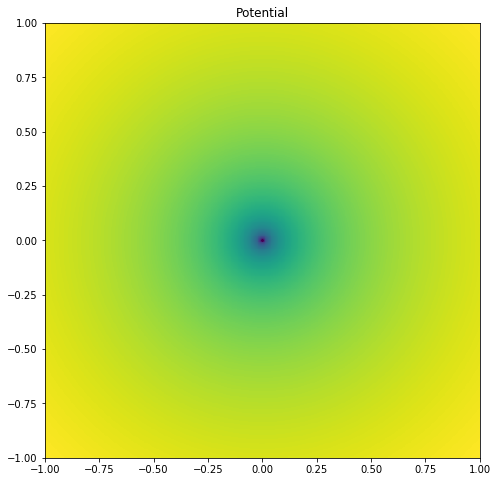

In [5]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize = (8,8))
ax.set_title('Potential')
ax.pcolormesh(x,y,potential)
ax.set(aspect=1);

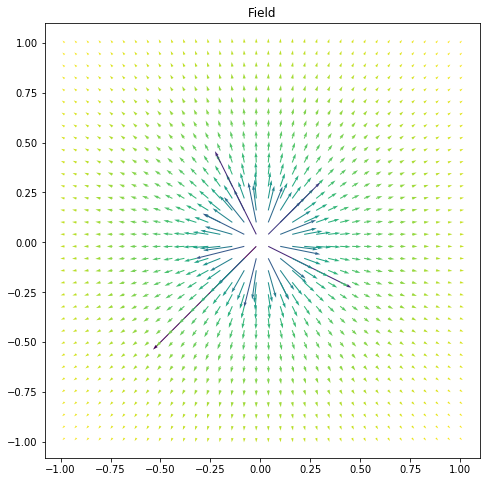

In [6]:
skip = (slice(None, None, 15), slice(None, None, 15))

fig, ax = plt.subplots(figsize = (8,8))
ax.set_title('Field')
ax.quiver(x[skip], y[skip], Ex[skip], Ey[skip], potential[skip])
ax.set(aspect=1);

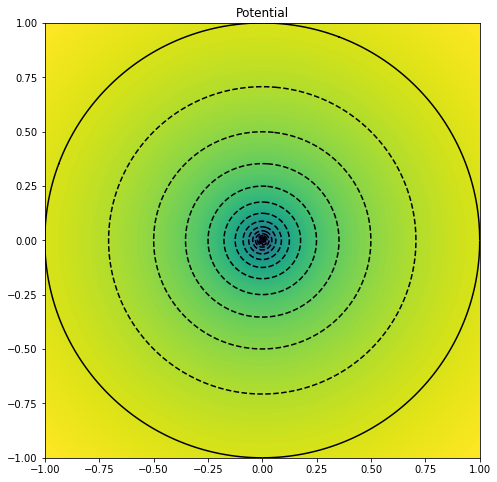

In [7]:
fig, ax = plt.subplots(figsize = (8,8))
ax.set_title('Potential')
ax.pcolormesh(x,y,potential)
ax.contour(x, y, potential, 20, colors = 'k')
ax.set(aspect = 1);

# Minimize Field over Region

First testing one V shaped array of rods

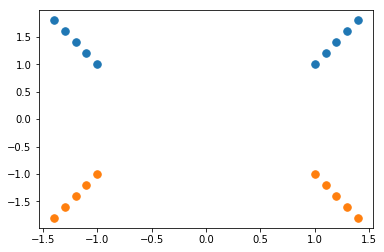

In [8]:
nwires = 5
x0wire = 1
y0wire = 1
dxwire = 0.1
dywire = 0.2
wires = np.zeros((3,4*nwires))
for n in range(nwires):
    wires[0][n] = -x0wire - n*dxwire
    wires[1][n] = y0wire + n*dywire
    wires[2][n] = 1
    wires[0][n+5] = x0wire + n*dxwire
    wires[1][n+5] = y0wire + n*dywire
    wires[2][n+5] = 1
    wires[0][n+10] = -x0wire - n*dxwire
    wires[1][n+10] = -y0wire - n*dywire
    wires[2][n+10] = -1
    wires[0][n+15] = x0wire + n*dxwire
    wires[1][n+15] = -y0wire - n*dywire
    wires[2][n+15] = -1
    
plt.plot(wires.T[wires[2] == 1].T[0], wires.T[wires[2] == 1].T[1], '.', ms = 15)
plt.plot(wires.T[wires[2] == 1].T[0], wires.T[wires[2] == -1].T[1], '.', ms = 15);

In [9]:
def wires_potential(x,y,wires):
    xwires = wires[0]
    ywires = wires[1]
    charge = wires[2]
    potential = np.zeros(x.shape)
    for xw,yw,cw in zip(xwires, ywires, charge):
        potential += Epotential(x, y, cw, xw, yw)
        
    potential[potential == np.inf] = np.nan
    potential[np.isnan(potential)] = np.nanmax(potential)
    potential[potential == -np.inf] = np.nan
    potential[np.isnan(potential)] = np.nanmin(potential)
    
    return potential

In [10]:
dx = .025
dy = .025
y,x = np.mgrid[-2:2:501j,-2:2:501j]
w = wires.copy()
w[2] = wires[1].copy()
potential = wires_potential(x,y,w)
Ey, Ex = np.gradient(-potential)
Ex /= dx
Ey /= dy

C:\Users\Olivier\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


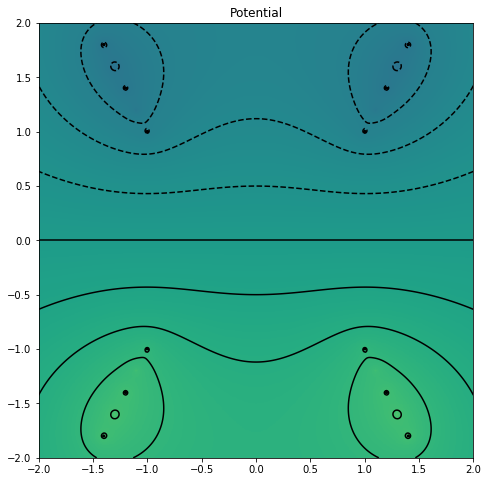

In [11]:
fig, ax = plt.subplots(figsize = (8,8))
ax.set_title('Potential')
ax.pcolormesh(x,y,potential)
ax.contour(x, y, potential, 30, colors = 'k')
ax.set(aspect = 1);

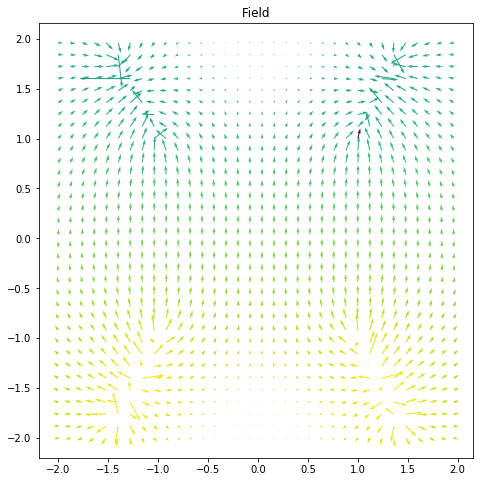

In [12]:
skip = (slice(None, None, 15), slice(None, None, 15))

fig, ax = plt.subplots(figsize = (8,8))
ax.set_title('Field')
ax.quiver(x[skip], y[skip], Ex[skip], Ey[skip], potential[skip])
ax.set(aspect=1);

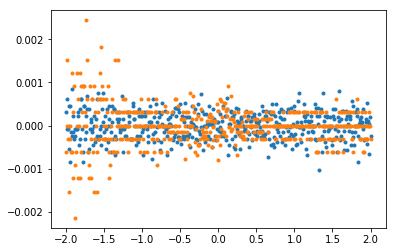

In [13]:
plt.plot(x[250,:], Ex[250,:], '.')
plt.plot(y[:,250], Ex[:,250], '.')

Minimization function minimizes the integral of $\frac{\left(E_y-E_y(0,0)\right)^2}{E_y(0,0)^2}$ over the surface the molecular beam interacts with.

In [14]:
def minimize_function(charges, x, y, wires):
    xc, yc = x.shape
    xc //= 2
    yc //= 2
    w = wires.copy()
    c = np.array(list(charges)*4)*w[2,:]
    w[2,:] = c
    potential = wires_potential(x, y, w)
    Ey, Ex = np.gradient(-potential)
    EyX, EyY = Ey[xc,:], Ey[xc,:]
#     EyT, EyR = Ey[0,:], Ey[:,0]
#     ExT, ExR = Ex[0,:], Ex[:,0]
    return ((EyX-Ey[xc,yc])**2).sum()/Ey[xc,yc]**2
#     return (EyX**2+EyY**2+EyT**2+EyR**2).sum()/(Ey[xc,yc])**2

In [15]:
y,x = np.mgrid[0.5:-0.5:101j,0.5:-0.5:101j]

In [16]:
from scipy.optimize import minimize
bounds = [(0,10)]*5
x0 = [1]*5
m = minimize(minimize_function, x0 = x0, bounds = bounds, args = (x, y, wires))

In [17]:
m

      fun: 0.010473015538724675
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.22474492e-02, 5.89492431e-03, 2.66708843e-03, 9.48859047e-04,
       1.40183004e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 66
      nit: 6
   status: 0
  success: True
        x: array([ 0.,  0.,  0.,  0., 10.])

It turns out that for a V shaped array of rods the most homogeneous field is generated by setting all rods to zero voltage except the furthest rod

In [18]:
w = wires.copy()
w[2,:] = w[2,:]*np.array(list(m.x)*4)
potential = wires_potential(x,y,w)
Ey, Ex = np.gradient(-potential)
Ex /= dx
Ey /= dy
E = np.sqrt(Ex**2+Ey**2)
xc, yc = E.shape
xc //= 2
yc //= 2

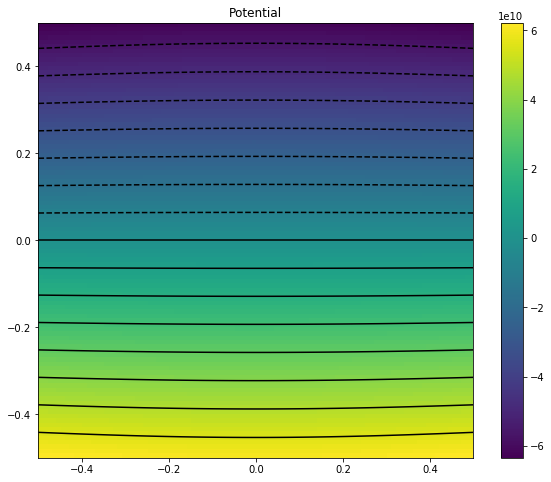

In [19]:
fig, ax = plt.subplots(figsize = (10,8))
ax.set_title('Potential')
pc = ax.pcolormesh(x,y,potential)
ax.contour(x, y, potential, 20, colors = 'k')
ax.set(aspect = 1);
fig.colorbar(pc);

maximum field inhomogeneity : 4.82 %


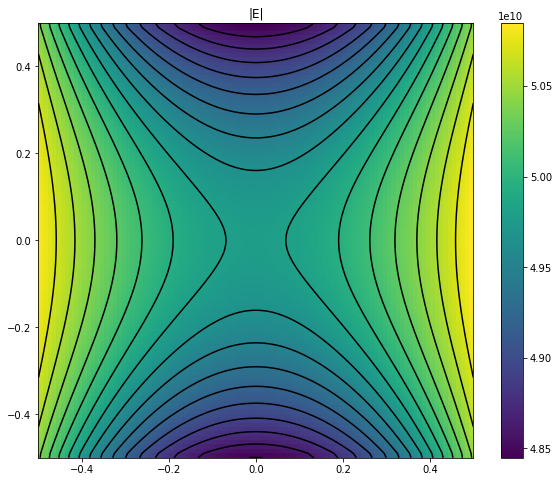

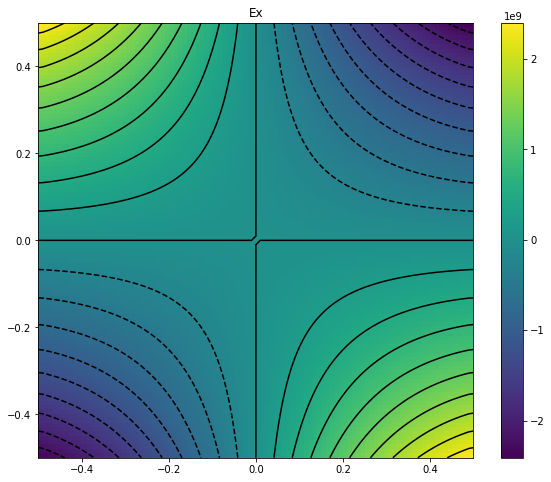

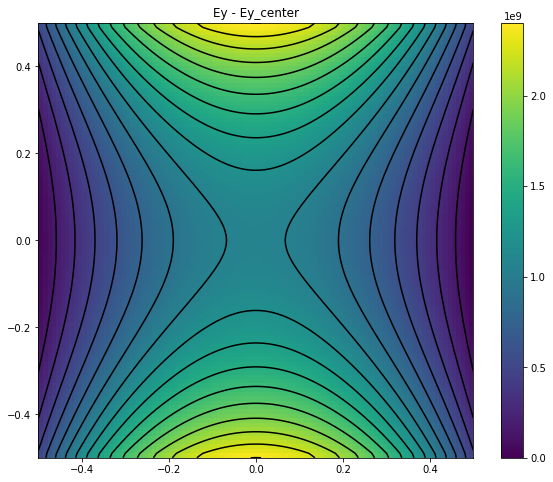

In [20]:
print('maximum field inhomogeneity : {0:.2f} %'.format(100*np.abs((E.ptp())/E[xc,yc])))

fig, ax = plt.subplots(figsize = (10,8))
ax.set_title('|E|')
pc = ax.pcolormesh(x, y, np.sqrt(Ex**2+Ey**2))
ax.contour(x, y, np.sqrt(Ex**2+Ey**2), 20, colors = 'k')
ax.set(aspect = 1);
fig.colorbar(pc);

fig, ax = plt.subplots(figsize = (10,8))
ax.set_title('Ex')
pc = ax.pcolormesh(x, y, Ex)
ax.contour(x, y, Ex, 20, colors = 'k')
ax.set(aspect = 1);
fig.colorbar(pc);

fig, ax = plt.subplots(figsize = (10,8))
ax.set_title('Ey - Ey_center')
pc = ax.pcolormesh(x, y, Ey-Ey.min())
ax.contour(x, y, Ey-Ey.min(), 20, colors = 'k')
ax.set(aspect = 1);
fig.colorbar(pc);

The other V shaped rod array

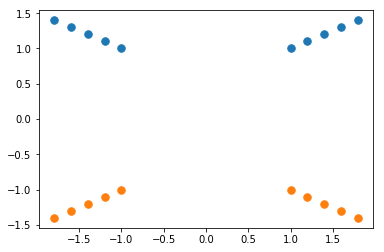

In [21]:
nwires = 5
x0wire = 1
y0wire = 1
dxwire = 0.2
dywire = 0.1
wires = np.zeros((3,4*nwires))
for n in range(nwires):
    wires[0][n] = -x0wire - n*dxwire
    wires[1][n] = y0wire + n*dywire
    wires[2][n] = 1
    wires[0][n+5] = x0wire + n*dxwire
    wires[1][n+5] = y0wire + n*dywire
    wires[2][n+5] = 1
    wires[0][n+10] = -x0wire - n*dxwire
    wires[1][n+10] = -y0wire - n*dywire
    wires[2][n+10] = -1
    wires[0][n+15] = x0wire + n*dxwire
    wires[1][n+15] = -y0wire - n*dywire
    wires[2][n+15] = -1
  
plt.plot(wires.T[wires[2] == 1].T[0], wires.T[wires[2] == 1].T[1], '.', ms = 15)
plt.plot(wires.T[wires[2] == 1].T[0], wires.T[wires[2] == -1].T[1], '.', ms = 15);

In [22]:
from scipy.optimize import minimize
bounds = [(0,10)]*5
x0 = [1]*5
m = minimize(minimize_function, x0 = x0, bounds = bounds, args = (x, y, wires))
m

      fun: 0.10651131977599451
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([6.79092241e-02, 4.59056182e-02, 2.55903299e-02, 1.04871486e-02,
       5.55111512e-09])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 114
      nit: 5
   status: 0
  success: True
        x: array([-1.11022302e-16,  0.00000000e+00,  0.00000000e+00, -2.22044605e-16,
        3.39208210e+00])

Also sets all voltages to zero except the furthest ones

In [23]:
w = wires.copy()
w[2,:] = w[2,:]*np.array(list(m.x)*4)
potential = wires_potential(x,y,w)
Ey, Ex = np.gradient(-potential)
Ex /= dx
Ey /= dy

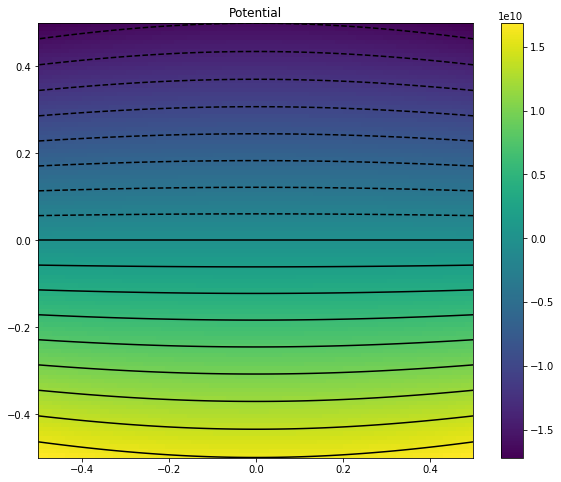

In [24]:
fig, ax = plt.subplots(figsize = (10,8))
ax.set_title('Potential')
pc = ax.pcolormesh(x,y,potential)
ax.contour(x, y, potential, 20, colors = 'k')
ax.set(aspect = 1);
fig.colorbar(pc);

maximum field inhomogeneity : 4.82 %


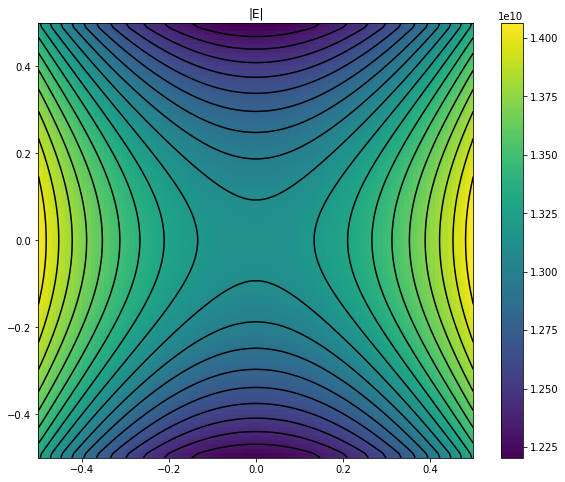

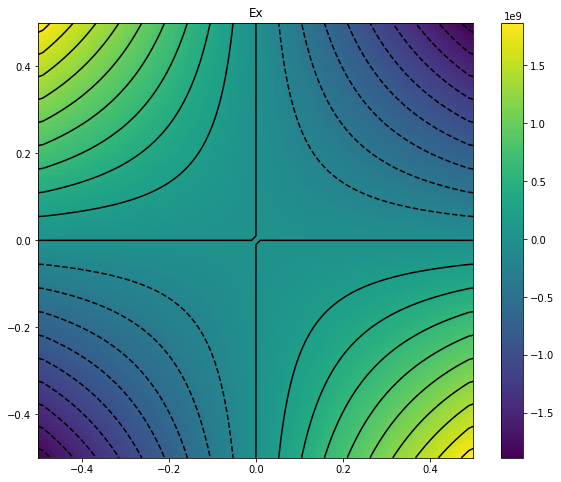

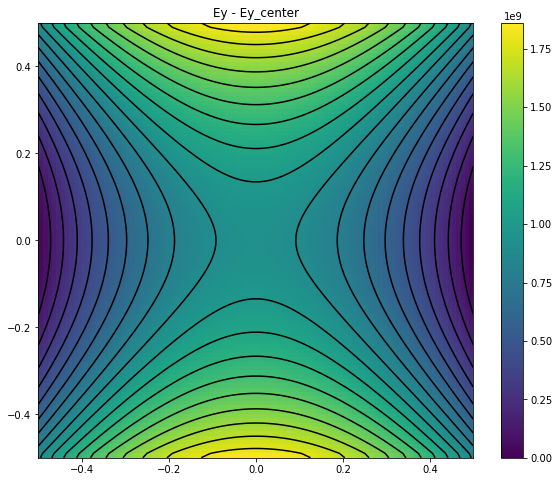

In [25]:
print('maximum field inhomogeneity : {0:.2f} %'.format(100*np.abs((E.ptp())/E[xc,yc])))

fig, ax = plt.subplots(figsize = (10,8))
ax.set_title('|E|')
pc = ax.pcolormesh(x, y, np.sqrt(Ex**2+Ey**2))
ax.contour(x, y, np.sqrt(Ex**2+Ey**2), 20, colors = 'k')
ax.set(aspect = 1);
fig.colorbar(pc);

fig, ax = plt.subplots(figsize = (10,8))
ax.set_title('Ex')
pc = ax.pcolormesh(x, y, Ex)
ax.contour(x, y, Ex, 20, colors = 'k')
ax.set(aspect = 1);
fig.colorbar(pc);

fig, ax = plt.subplots(figsize = (10,8))
ax.set_title('Ey - Ey_center')
pc = ax.pcolormesh(x, y, Ey-Ey.min())
ax.contour(x, y, Ey-Ey.min(), 20, colors = 'k')
ax.set(aspect = 1);
fig.colorbar(pc);

# Horizontal wires

Array of wirees spanned horizontally over the molecular beam, beam comes out of screen. With the microwave polarization at a $45^\circ$ angle to the wires, half the power should get to the interaction region

### Wires at fixed positions; voltage varied

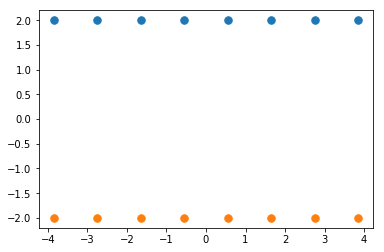

In [53]:
nwires = 4
x0wire = .55
y0wire = 2
dxwire = 1.1
dywire = 0
wires = np.zeros((3,4*nwires))
for n in range(nwires):
    wires[0][n] = -x0wire - n*dxwire
    wires[1][n] = y0wire + n*dywire
    wires[2][n] = 1
    wires[0][n+nwires] = x0wire + n*dxwire
    wires[1][n+nwires] = y0wire + n*dywire
    wires[2][n+nwires] = 1
    wires[0][n+nwires*2] = -x0wire - n*dxwire
    wires[1][n+nwires*2] = -y0wire - n*dywire
    wires[2][n+nwires*2] = -1
    wires[0][n+nwires*3] = x0wire + n*dxwire
    wires[1][n+nwires*3] = -y0wire - n*dywire
    wires[2][n+nwires*3] = -1
    
plt.plot(wires.T[wires[2] == 1].T[0], wires.T[wires[2] == 1].T[1], '.', ms = 15)
plt.plot(wires.T[wires[2] == 1].T[0], wires.T[wires[2] == -1].T[1], '.', ms = 15);

In [54]:
dx = .025
dy = .025
y,x = np.mgrid[-2.5:2.5:2001j,-5:5:2001j]
w = wires.copy()
potential = wires_potential(x,y,w)
Ey, Ex = np.gradient(-potential)
Ex /= dx
Ey /= dy

C:\Users\Olivier\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


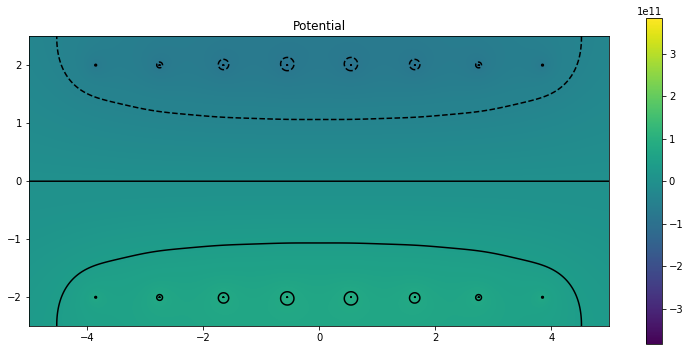

In [55]:
fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('Potential')
pc = ax.pcolormesh(x,y,potential)
ax.contour(x, y, potential, 20, colors = 'k')
ax.set(aspect = 1);
fig.colorbar(pc);

In [56]:
dx = .025
dy = .025
y,x = np.mgrid[-.6:.6:501j,-1.2:1.2:1001j]
w = wires.copy()
potential = wires_potential(x,y,w)
Ey, Ex = np.gradient(-potential)
Ex /= dx
Ey /= dy
E = np.sqrt(Ex**2+Ey**2)

maximum field inhomogeneity : 2.52 %


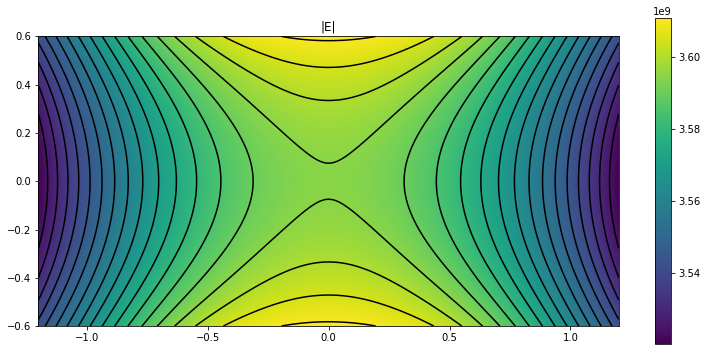

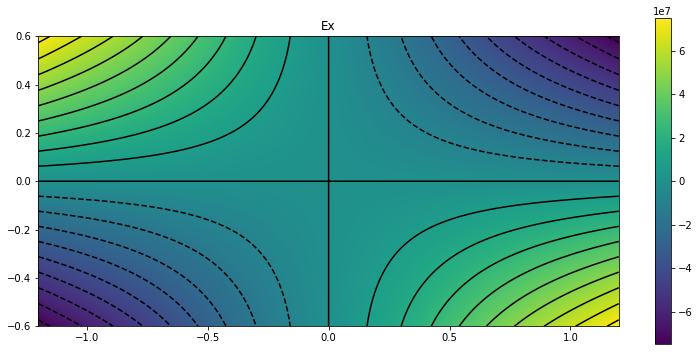

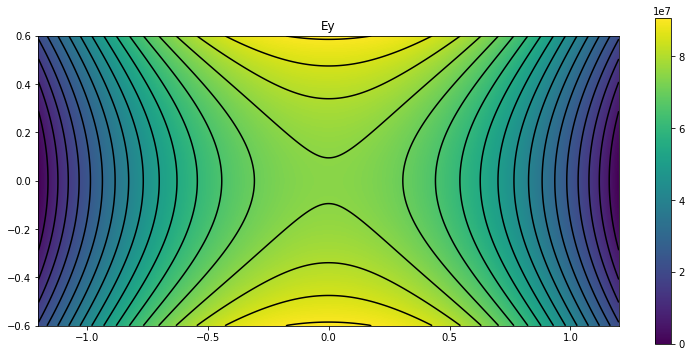

In [57]:
xc, yc = E.shape
xc //= 2
yc //= 2
print('maximum field inhomogeneity : {0:.2f} %'.format(100*np.abs((E.ptp())/E[xc,yc])))

fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('|E|')
pc = ax.pcolormesh(x, y, np.sqrt(Ex**2+Ey**2))
ax.contour(x, y, np.sqrt(Ex**2+Ey**2), 20, colors = 'k')
ax.set(aspect = 1);
fig.colorbar(pc);

fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('Ex')
pc = ax.pcolormesh(x, y, Ex)
ax.contour(x, y, Ex, 20, colors = 'k')
ax.set(aspect = 1);
fig.colorbar(pc);

fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('Ey')
pc = ax.pcolormesh(x, y, Ey-Ey.min())
ax.contour(x, y, Ey-Ey.min(), 20, colors = 'k')
ax.set(aspect = 1);
fig.colorbar(pc);

In [58]:
def minimize_function(charges, x, y, wires):
    xc, yc = x.shape
    xc //= 2
    yc //= 2
    w = wires.copy()
    c = np.array(list(charges)*4)*w[2,:]
    w[2,:] = c
    potential = wires_potential(x, y, w)
    Ey, Ex = np.gradient(-potential)
    EyX, EyY = Ey[xc,:], Ey[xc,:]
#     EyT, EyR = Ey[0,:], Ey[:,0]
#     ExT, ExR = Ex[0,:], Ex[:,0]
    return ((Ey-Ey[xc,yc])**2).sum()/Ey[xc,yc]**2
#     return ((EyX-Ey[xc,yc])**2).sum()/Ey[xc,yc]**2
#     return (EyX**2+EyY**2+EyT**2+EyR**2).sum()/(Ey[xc,yc])**2

In [59]:
y,x = np.mgrid[-.6:.6:101j,-1.2:1.2:201j]

Method 'SLSQP' gives the best result when setting the voltages/charges to 1 decimal point.  
Default method is 'L-BFGS-B', which gives a much better result without a decimal point limit.

In [60]:
from scipy.optimize import minimize
bounds = [(0,10)]*nwires
x0 = [1]*nwires
m = minimize(minimize_function, x0 = x0, bounds = bounds, args = (x, y, wires), method = 'L-BFGS-B')
m

      fun: 0.00018327061461743507
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.93935565e-05,  3.41595757e-05, -1.00167623e-05,  6.03207669e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 85
      nit: 13
   status: 0
  success: True
        x: array([0.90947208, 0.85950242, 1.34849646, 1.22083994])

In [61]:
w = wires.copy()
w[2] = np.array(list(m.x)*4)*w[2,:]
potential = wires_potential(x,y,w)
Ey, Ex = np.gradient(-potential)
Ex /= dx
Ey /= dy
E = np.sqrt(Ex**2+Ey**2)

maximum field inhomogeneity : 0.07 %


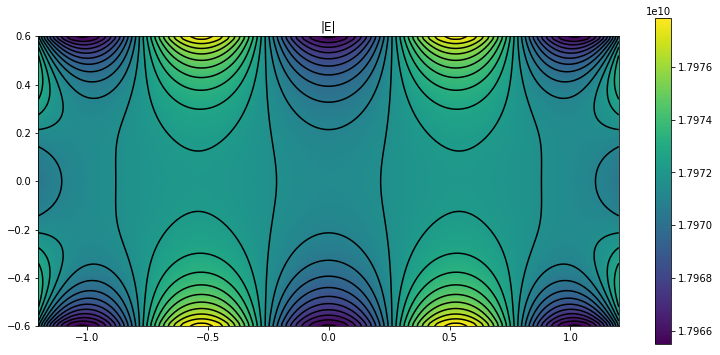

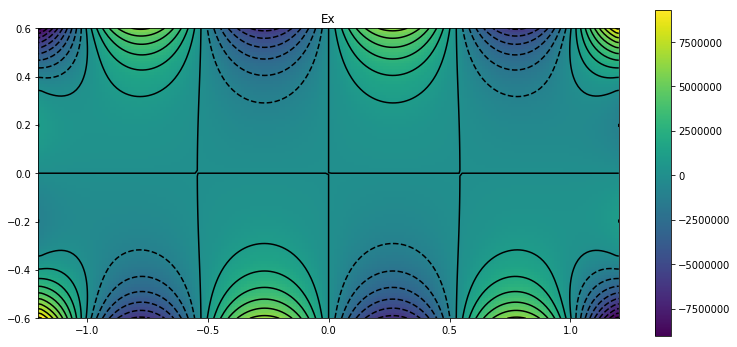

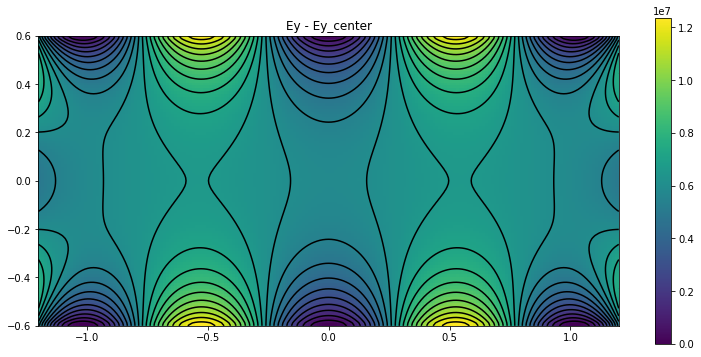

In [62]:
xc, yc = E.shape
xc //= 2
yc //= 2
print('maximum field inhomogeneity : {0:.2f} %'.format(100*np.abs((E.ptp())/E[xc,yc])))

fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('|E|')
pc = ax.pcolormesh(x, y, E)
ax.contour(x, y, E, 20, colors = 'k')
ax.set(aspect = 1);
fig.colorbar(pc);

fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('Ex')
pc = ax.pcolormesh(x, y, Ex)
ax.contour(x, y, Ex, 20, colors = 'k')
ax.set(aspect = 1);
fig.colorbar(pc);

fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('Ey - Ey_center')
pc = ax.pcolormesh(x, y, Ey-Ey.min())
ax.contour(x, y, Ey-Ey.min(), 20, colors = 'k')
ax.set(aspect = 1);
fig.colorbar(pc);

In [63]:
x0 = m.x.round(1)
print(x0)
print(np.unique(x0).size)

w = wires.copy()
w[2] = np.array(list(x0)*4)*w[2,:]
potential = wires_potential(x,y,w)
Ey, Ex = np.gradient(-potential)
Ex /= dx
Ey /= dy
E = np.sqrt(Ex**2+Ey**2)

[0.9 0.9 1.3 1.2]
3


maximum field inhomogeneity : 0.12 %


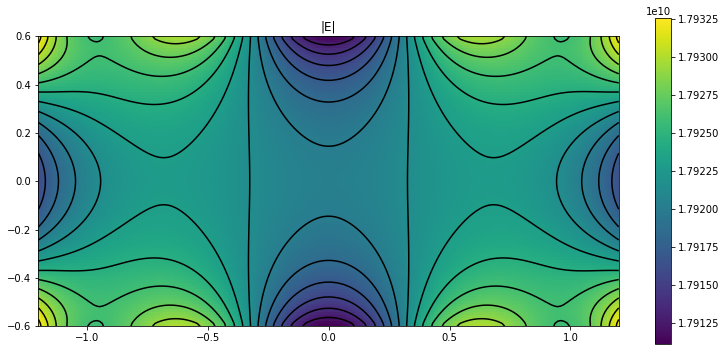

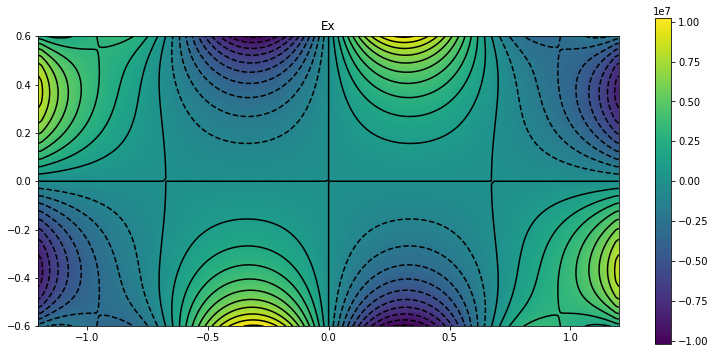

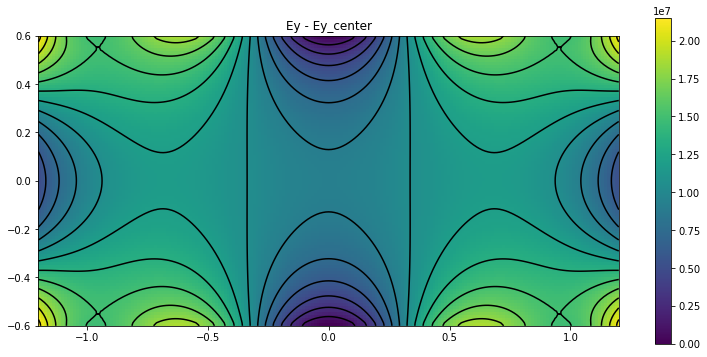

In [64]:
xc, yc = E.shape
xc //= 2
yc //= 2
print('maximum field inhomogeneity : {0:.2f} %'.format(100*np.abs((E.ptp())/E[xc,yc])))

fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('|E|')
pc = ax.pcolormesh(x, y, E)
ax.contour(x, y, E, 20, colors = 'k')
ax.set(aspect = 1);
fig.colorbar(pc);

fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('Ex')
pc = ax.pcolormesh(x, y, Ex)
ax.contour(x, y, Ex, 20, colors = 'k')
ax.set(aspect = 1);
fig.colorbar(pc);

fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('Ey - Ey_center')
pc = ax.pcolormesh(x, y, Ey-Ey.min())
ax.contour(x, y, Ey-Ey.min(), 20, colors = 'k')
ax.set(aspect = 1);
fig.colorbar(pc);

randomly adding +/- 0.1 to the charges found in the optimization sequence to find the minimum.  

In [65]:
mmin = minimize_function(x0, x, y, wires)
print('iter #{0:>6} : mmin = {1:.2e}'.format(0, mmin))
cmin = np.zeros(x0.size)
iters = 0
np.random.seed(1)
while True:
    try:
        iters += 1
        c = x0.copy()
        c += np.abs(np.random.randint(-3,3,nwires)/10)
        mm = minimize_function(c, x, y, wires)
        if mm < mmin:
            print('iter #{0:>6} : mmin = {1:.2e}'.format(iters, mm))
            mmin = mm
            cmin = c
    except KeyboardInterrupt:
        print()
        print('Stop random minimum finder after {0} iterations'.format(iters))
        print('start mmin : {0:.2e}; stop mmin {1:.2e}'.format(minimize_function(x0, x, y, wires), mmin))
        print()
        print(cmin)
        break

iter #     0 : mmin = 9.62e-04
iter #     6 : mmin = 5.74e-04
iter #  2882 : mmin = 3.58e-04

Stop random minimum finder after 4037 iterations
start mmin : 9.62e-04; stop mmin 3.58e-04

[1.  0.9 1.6 1.2]


In [66]:
print(len(np.unique(cmin)))

4


In [67]:
w = wires.copy()
w[2] = np.array(list(cmin)*4)*w[2,:]
potential = wires_potential(x,y,w)
Ey, Ex = np.gradient(-potential)
Ex /= dx
Ey /= dy
E = np.sqrt(Ex**2+Ey**2)

maximum field inhomogeneity : 0.09 %


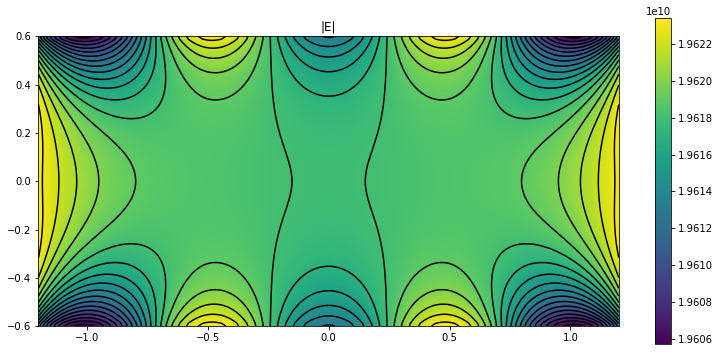

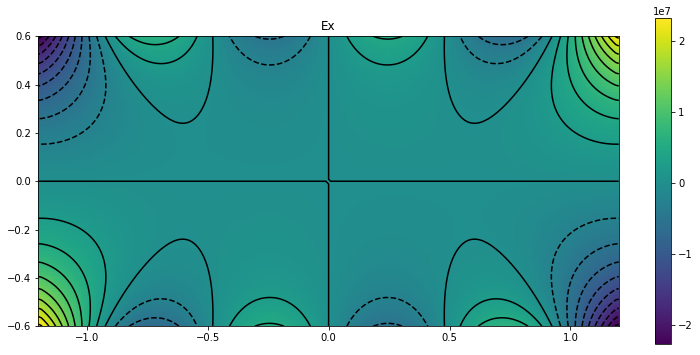

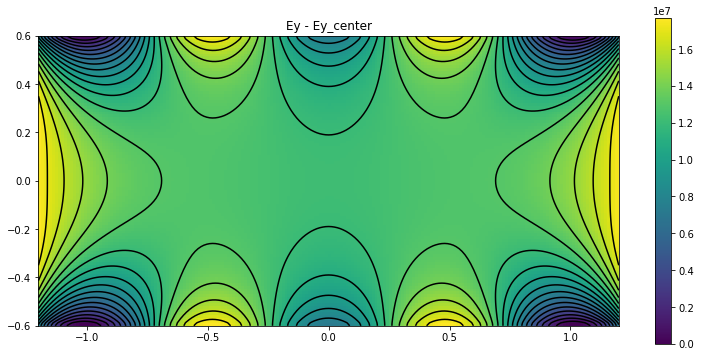

In [68]:
xc, yc = E.shape
xc //= 2
yc //= 2
print('maximum field inhomogeneity : {0:.2f} %'.format(100*np.abs((E.ptp())/E[xc,yc])))

fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('|E|')
pc = ax.pcolormesh(x, y, E)
ax.contour(x, y, E, 20, colors = 'k')
ax.set(aspect = 1);
fig.colorbar(pc);
fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('Ex')
pc = ax.pcolormesh(x, y, Ex)
ax.contour(x, y, Ex, 20, colors = 'k')
ax.set(aspect = 1);
fig.colorbar(pc);

fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('Ey - Ey_center')
pc = ax.pcolormesh(x, y, Ey-Ey.min())
ax.contour(x, y, Ey-Ey.min(), 20, colors = 'k')
ax.set(aspect = 1);
fig.colorbar(pc);

In [69]:
dx = .025
dy = .025
y,x = np.mgrid[-2.5:2.5:501j,-4:4:501j]

w = wires.copy()
w[2] = np.array(list(m.x)*4)*w[2,:]
potential = wires_potential(x,y,w)
Ey, Ex = np.gradient(-potential)
Ex /= dx
Ey /= dy

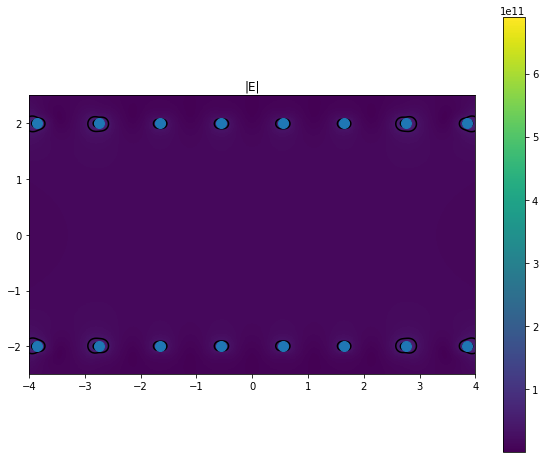

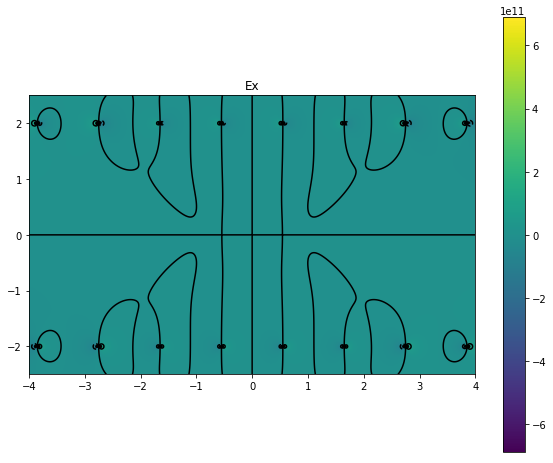

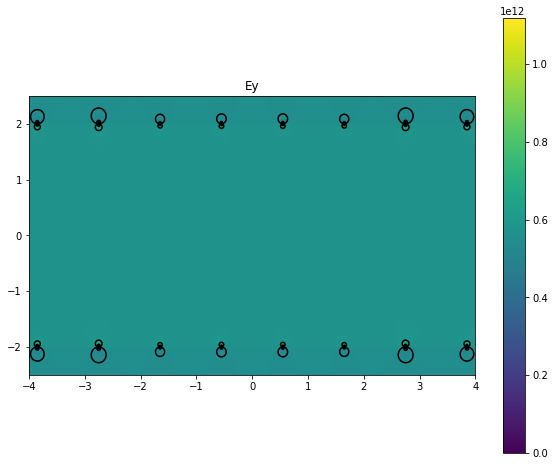

In [70]:
fig, ax = plt.subplots(figsize = (10,8))
ax.set_title('|E|')
pc = ax.pcolormesh(x, y, np.sqrt(Ex**2+Ey**2))
ax.contour(x, y, np.sqrt(Ex**2+Ey**2), 20, colors = 'k')
ax.set(aspect = 1);
fig.colorbar(pc);
ax.plot(wires[0,:], wires[1,:], '.', ms = 20)

fig, ax = plt.subplots(figsize = (10,8))
ax.set_title('Ex')
pc = ax.pcolormesh(x, y, Ex)
ax.contour(x, y, Ex, 20, colors = 'k')
ax.set(aspect = 1);
fig.colorbar(pc);

fig, ax = plt.subplots(figsize = (10,8))
ax.set_title('Ey')
pc = ax.pcolormesh(x, y, Ey-Ey.min())
ax.contour(x, y, Ey-Ey.min(), 20, colors = 'k')
ax.set(aspect = 1);
fig.colorbar(pc);

# Both V shaped rod arrays

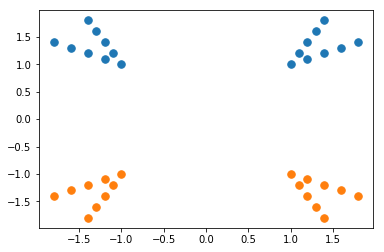

In [44]:
nwires = 5
x0wire = 1
x0wire2 = 1
y0wire = 1
y0wire2 = 1
dxwire = 0.1
dywire = 0.2
dxwire2 = 0.2
dywire2 = 0.1
wires = np.zeros((3,4*nwires+4*(nwires-1)))
for n in range(nwires):
    wires[0][n] = -x0wire - n*dxwire
    wires[1][n] = y0wire + n*dywire
    wires[2][n] = 1
    wires[0][n+5] = x0wire + n*dxwire
    wires[1][n+5] = y0wire + n*dywire
    wires[2][n+5] = 1
    wires[0][n+10] = -x0wire - n*dxwire
    wires[1][n+10] = -y0wire - n*dywire
    wires[2][n+10] = -1
    wires[0][n+15] = x0wire + n*dxwire
    wires[1][n+15] = -y0wire - n*dywire
    wires[2][n+15] = -1
    if n > 0:
        wires[0][n+19] = -x0wire2 - n*dxwire2
        wires[1][n+19] = y0wire2 + n*dywire2
        wires[2][n+19] = 1
        wires[0][n+23] = x0wire2 + n*dxwire2
        wires[1][n+23] = y0wire2 + n*dywire2
        wires[2][n+23] = 1
        wires[0][n+27] = - x0wire2 - n*dxwire2
        wires[1][n+27] = - y0wire2 - n*dywire2
        wires[2][n+27] = -1
        wires[0][n+31] = x0wire2 + n*dxwire2
        wires[1][n+31] = -y0wire2 - n*dywire2
        wires[2][n+31] = -1

plt.plot(wires.T[wires[2] == 1].T[0], wires.T[wires[2] == 1].T[1], '.', ms = 15)
plt.plot(wires.T[wires[2] == 1].T[0], wires.T[wires[2] == -1].T[1], '.', ms = 15);

In [45]:
def minimize_function(charges, x, y, wires):
    xc, yc = x.shape
    xc //= 2
    yc //= 2
    w = wires.copy()
    c = np.array(list(charges[:5])*4)*w[2,:20]
    w[2,:20] = c
    c = np.array(list(charges[5:])*4)*w[2,20:]
    w[2,20:] = c
    potential = wires_potential(x, y, w)
    Ey, Ex = np.gradient(-potential)
    EyX, EyY = Ey[xc,:], Ey[xc,:]
#     EyT, EyR = Ey[0,:], Ey[:,0]
#     ExT, ExR = Ex[0,:], Ex[:,0]
    return ((Ey-Ey[xc,yc])**2).sum()/Ey[xc,yc]**2
    return ((EyX-Ey[xc,yc])**2).sum()/Ey[xc,yc]**2
#     return (EyX**2+EyY**2+EyT**2+EyR**2).sum()/(Ey[xc,yc])**2

In [46]:
dx = .025
dy = .025
y,x = np.mgrid[-.5:.5:501j,-.5:.5:501j]

In [47]:
from scipy.optimize import minimize
bounds = [(0,100)]*9
x0 = [1, 1.2, 1.4, 1.6, 1.8, 1.1, 1.2, 1.3, 1.4]
m = minimize(minimize_function, x0 = x0, bounds = bounds, args = (x, y, wires))
m

      fun: 28.064297782262233
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([7.81056002e+00, 3.75835327e+00, 1.69196319e+00, 5.97324856e-01,
       4.43556303e-03, 5.37180185e+00, 3.71390065e+00, 2.59393040e+00,
       1.82788007e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 200
      nit: 5
   status: 0
  success: True
        x: array([ 0.        ,  0.        ,  0.        ,  0.        , 43.44901014,
        0.        ,  0.        ,  0.        ,  0.        ])

Again all voltages except the voltages for the furthest rods are set to zero

In [48]:
x0
w = wires.copy()
c = np.array(list(m.x[:5])*4)*w[2,:20]
w[2,:20] = c
c = np.array(list(m.x[5:])*4)*w[2,20:]
w[2,20:] = c

potential = wires_potential(x,y,w)
Ey, Ex = np.gradient(-potential)
Ex /= dx
Ey /= dy
E = np.sqrt(Ex**2+Ey**2)

xc, yc = E.shape
xc //= 2
yc //= 2

maximum field inhomogeneity : 4.87 %


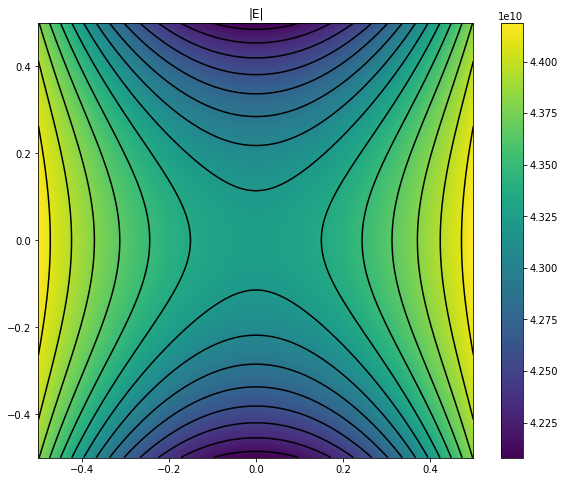

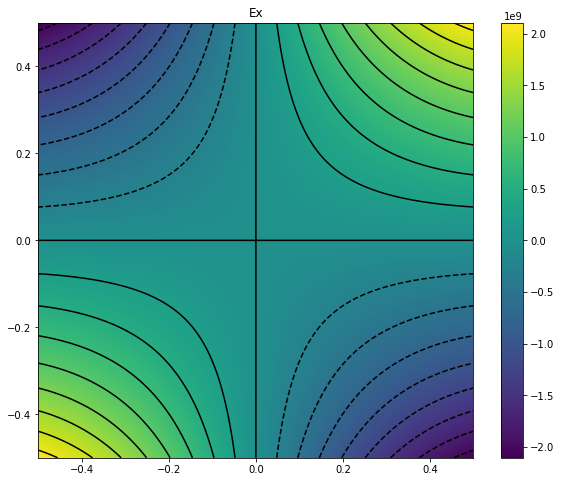

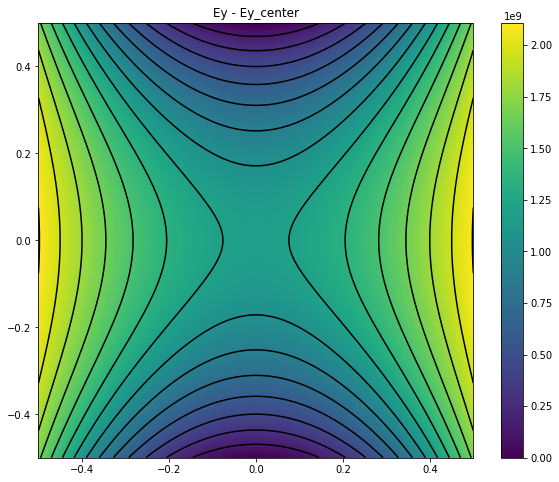

In [49]:
print('maximum field inhomogeneity : {0:.2f} %'.format(100*np.abs((E.ptp())/E[xc,yc])))

fig, ax = plt.subplots(figsize = (10,8))
ax.set_title('|E|')
pc = ax.pcolormesh(x, y, E)
ax.contour(x, y, E, 20, colors = 'k')
ax.set(aspect = 1);
fig.colorbar(pc);

fig, ax = plt.subplots(figsize = (10,8))
ax.set_title('Ex')
pc = ax.pcolormesh(x, y, Ex)
ax.contour(x, y, Ex, 20, colors = 'k')
ax.set(aspect = 1);
fig.colorbar(pc);

fig, ax = plt.subplots(figsize = (10,8))
ax.set_title('Ey - Ey_center')
pc = ax.pcolormesh(x, y, Ey-Ey.min())
ax.contour(x, y, Ey-Ey.min(), 20, colors = 'k')
ax.set(aspect = 1);
fig.colorbar(pc);